In [1]:
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tqdm.auto import tqdm

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


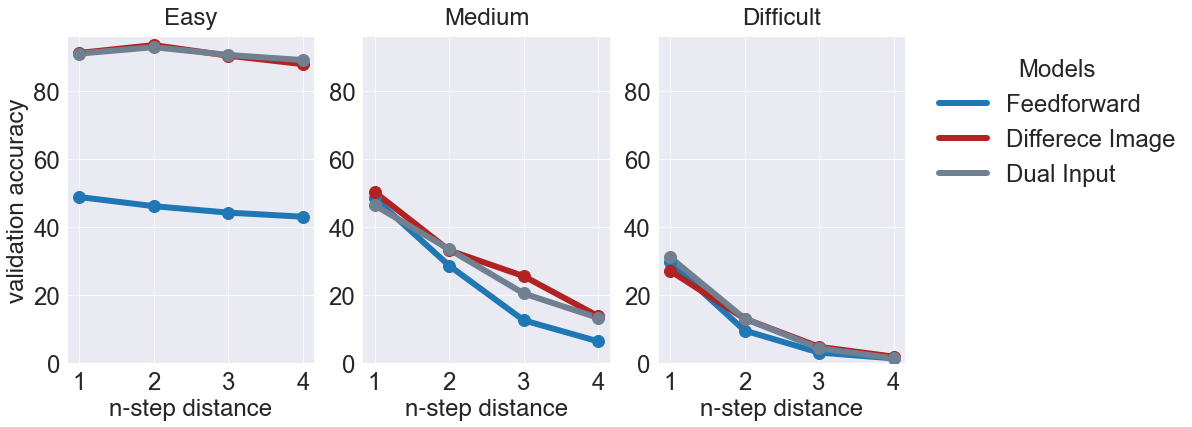

In [2]:
x = [1, 2, 3, 4]

# validation set
feedforward_maze_easy = [48.8, 46.1, 44.2, 43.0]
feedforward_maze_medium = [48.5, 28.6, 12.5, 6.3]
feedforward_maze_difficult = [29.6, 9.5, 3.0, 1.3]

diffImg_maze_easy = [91.2, 93.5, 90.4, 87.9]
diffImg_maze_medium = [50.3, 33.1, 25.5, 13.7]
diffImg_maze_difficult = [27.1, 13.0, 4.7, 1.8]

dualImg_maze_easy = [91.0, 92.9, 90.6, 89.1]
dualImg_maze_medium = [46.4, 33.4, 20.4, 13.2]
dualImg_maze_difficult = [31.1, 13.0, 4.3, 1.3]

from matplotlib import pyplot as plt
import numpy as np

font = 24
hfont = {"fontname": "Helvetica"}

# plt.rcParams["figure.figsize"] = 25, 5.5
plt.rcParams.update({"font.size": font})
plt.rcParams["axes.titlepad"] = 13
plt.rcParams["xtick.major.pad"] = "8"  # axis distance
plt.rcParams["ytick.major.pad"] = "8"

plt.figure(figsize=(15, 6))

with plt.style.context("seaborn-darkgrid"):

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.title("Model performance", fontsize=font)
    plt.ylabel("validation accuracy", fontsize=font, **hfont)
    plt.xlabel("n-step distance", fontsize=font, **hfont)

    # easy
    plt.subplot(1, 3, 1)
    (y1,) = plt.plot(
        x,
        feedforward_maze_easy,
        linestyle="solid",
        c="tab:blue",
        label="Feedforward",
        linewidth=6.0,
    )
    (y2,) = plt.plot(
        x,
        diffImg_maze_easy,
        c="firebrick",
        linestyle="solid",
        label="Differece Image",
        linewidth=6.0,
    )
    (y3,) = plt.plot(
        x,
        dualImg_maze_easy,
        c="slategray",
        linestyle="solid",
        label="Dual Input",
        linewidth=6.0,
    )

    plt.plot(
        x,
        feedforward_maze_easy,
        c="tab:blue",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )
    plt.plot(
        x,
        diffImg_maze_easy,
        c="firebrick",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )
    plt.plot(
        x,
        dualImg_maze_easy,
        c="slategray",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )

    plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
    plt.ylim(ymax=96, ymin=0)
    plt.yticks(np.arange(0, 95 + 1, 20.0))
    plt.ylabel("validation accuracy", fontsize=font, **hfont)
    plt.xlabel("n-step distance", fontsize=font, **hfont)
    plt.title("Easy", fontsize=font, **hfont)

    # medium
    plt.subplot(1, 3, 2)
    plt.plot(
        x,
        feedforward_maze_medium,
        linestyle="solid",
        c="tab:blue",
        label="Feedforward.",
        linewidth=6.0,
    )
    plt.plot(
        x,
        diffImg_maze_medium,
        linestyle="solid",
        c="firebrick",
        label="DiffImage",
        linewidth=6.0,
    )
    plt.plot(
        x,
        dualImg_maze_medium,
        c="slategray",
        linestyle="solid",
        label="DualInput",
        linewidth=6.0,
    )

    plt.plot(
        x,
        feedforward_maze_medium,
        c="tab:blue",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )
    plt.plot(
        x,
        diffImg_maze_medium,
        c="firebrick",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )
    plt.plot(
        x,
        dualImg_maze_medium,
        c="slategray",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )

    plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
    plt.ylim(ymax=96, ymin=0)
    plt.yticks(np.arange(0, 95 + 1, 20.0))
    plt.xlabel("n-step distance", fontsize=font, **hfont)
    plt.title("Medium", fontsize=font, **hfont)

    # difficult
    plt.subplot(1, 3, 3)
    plt.plot(
        x,
        feedforward_maze_difficult,
        linestyle="solid",
        c="tab:blue",
        label="Feedforward.",
        linewidth=6.0,
    )
    plt.plot(
        x,
        diffImg_maze_difficult,
        linestyle="solid",
        c="firebrick",
        label="Differece Image",
        linewidth=6.0,
    )
    plt.plot(
        x,
        dualImg_maze_difficult,
        c="slategray",
        linestyle="solid",
        label="Dual Input",
        linewidth=6.0,
    )

    plt.plot(
        x,
        feedforward_maze_difficult,
        c="tab:blue",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )
    plt.plot(
        x,
        diffImg_maze_difficult,
        c="firebrick",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )
    plt.plot(
        x,
        dualImg_maze_difficult,
        c="slategray",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )

    plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
    plt.ylim(ymax=96, ymin=0)
    plt.yticks(np.arange(0, 95 + 1, 20.0))
    plt.xlabel("n-step distance", fontsize=font, **hfont)
    plt.title("Difficult", fontsize=font, **hfont)

    # plt.legend()
    plt.legend(
        handles=[y1, y2, y3], title="Models", bbox_to_anchor=(1.05, 1), loc="upper left"
    )
    plt.savefig("feedforward-action-prediction.pdf", bbox_inches="tight")
    plt.show()

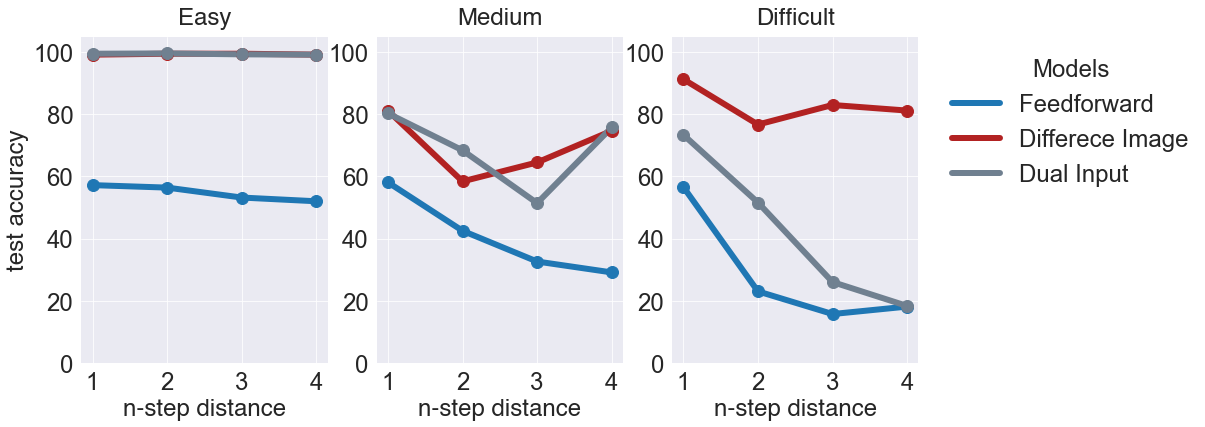

In [8]:
x = [1, 2, 3, 4]

# test set
feedforward_maze_easy = [57.2, 56.4, 53.2, 52.0]
feedforward_maze_medium = [58.1, 42.5, 32.6, 29.1]
feedforward_maze_difficult = [56.6, 23.0, 15.7, 18.1]

diffImg_maze_easy = [99.2, 99.5, 99.5, 99.2]
diffImg_maze_medium = [81.2, 58.4, 64.5, 74.7]
diffImg_maze_difficult = [91.3, 76.7, 83.0, 81.2]

dualImg_maze_easy = [99.5, 99.6, 99.3, 99.2]
dualImg_maze_medium = [80.3, 68.4, 51.4, 75.8]
dualImg_maze_difficult = [73.4, 51.6, 26.0, 18.3]

from matplotlib import pyplot as plt
import numpy as np

font = 24
hfont = {"fontname": "Helvetica"}

# plt.rcParams["figure.figsize"] = 25, 5.5
plt.rcParams.update({"font.size": font})
plt.rcParams["axes.titlepad"] = 13
plt.rcParams["xtick.major.pad"] = "8"  # axis distance
plt.rcParams["ytick.major.pad"] = "8"

plt.figure(figsize=(15, 6))

with plt.style.context("seaborn-darkgrid"):

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.title("Model performance", fontsize=font)
    plt.ylabel("validation accuracy", fontsize=font, **hfont)
    plt.xlabel("n-step distance", fontsize=font, **hfont)

    # easy
    plt.subplot(1, 3, 1)
    (y1,) = plt.plot(
        x,
        feedforward_maze_easy,
        linestyle="solid",
        c="tab:blue",
        label="Feedforward",
        linewidth=6.0,
    )
    (y2,) = plt.plot(
        x,
        diffImg_maze_easy,
        c="firebrick",
        linestyle="solid",
        label="Differece Image",
        linewidth=6.0,
    )
    (y3,) = plt.plot(
        x,
        dualImg_maze_easy,
        c="slategray",
        linestyle="solid",
        label="Dual Input",
        linewidth=6.0,
    )

    plt.plot(
        x,
        feedforward_maze_easy,
        c="tab:blue",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )
    plt.plot(
        x,
        diffImg_maze_easy,
        c="firebrick",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )
    plt.plot(
        x,
        dualImg_maze_easy,
        c="slategray",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )

    plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
    plt.ylim(ymax=100 + 5, ymin=0)
    plt.yticks(np.arange(0, 100 + 5, 20.0))
    plt.ylabel("test accuracy", fontsize=font, **hfont)
    plt.xlabel("n-step distance", fontsize=font, **hfont)
    plt.title("Easy", fontsize=font, **hfont)

    # medium
    plt.subplot(1, 3, 2)
    plt.plot(
        x,
        feedforward_maze_medium,
        linestyle="solid",
        c="tab:blue",
        label="Feedforward.",
        linewidth=6.0,
    )
    plt.plot(
        x,
        diffImg_maze_medium,
        linestyle="solid",
        c="firebrick",
        label="DiffImage",
        linewidth=6.0,
    )
    plt.plot(
        x,
        dualImg_maze_medium,
        c="slategray",
        linestyle="solid",
        label="DualInput",
        linewidth=6.0,
    )

    plt.plot(
        x,
        feedforward_maze_medium,
        c="tab:blue",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )
    plt.plot(
        x,
        diffImg_maze_medium,
        c="firebrick",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )
    plt.plot(
        x,
        dualImg_maze_medium,
        c="slategray",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )

    plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
    plt.ylim(ymax=100 + 5, ymin=0)
    plt.yticks(np.arange(0, 100 + 5, 20.0))
    plt.xlabel("n-step distance", fontsize=font, **hfont)
    plt.title("Medium", fontsize=font, **hfont)

    # difficult
    plt.subplot(1, 3, 3)
    plt.plot(
        x,
        feedforward_maze_difficult,
        linestyle="solid",
        c="tab:blue",
        label="Feedforward.",
        linewidth=6.0,
    )
    plt.plot(
        x,
        diffImg_maze_difficult,
        linestyle="solid",
        c="firebrick",
        label="Differece Image",
        linewidth=6.0,
    )
    plt.plot(
        x,
        dualImg_maze_difficult,
        c="slategray",
        linestyle="solid",
        label="Dual Input",
        linewidth=6.0,
    )

    plt.plot(
        x,
        feedforward_maze_difficult,
        c="tab:blue",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )
    plt.plot(
        x,
        diffImg_maze_difficult,
        c="firebrick",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )
    plt.plot(
        x,
        dualImg_maze_difficult,
        c="slategray",
        linestyle="None",
        marker="o",
        markersize=12.0,
    )

    plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
    plt.ylim(ymax=100 + 5, ymin=0)
    plt.yticks(np.arange(0, 100 + 5, 20.0))
    plt.xlabel("n-step distance", fontsize=font, **hfont)
    plt.title("Difficult", fontsize=font, **hfont)

    # plt.legend()
    plt.legend(
        handles=[y1, y2, y3], title="Models", bbox_to_anchor=(1.05, 1), loc="upper left"
    )
    plt.savefig("feedforward-action-prediction_test_set.pdf", bbox_inches="tight")
    plt.show()